# DCGAN para Fashion-MNIST
Desarrollado siguiendo el ejemplo de [pyimagesearch](https://www.pyimagesearch.com/2021/11/11/get-started-dcgan-for-fashion-mnist/).
Esta basado en el paper [Unsupervised Representation Learning with Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).
Fue uno de los primeros papers dedicados a GAN y es un Must-Read si quieres utilizar GAN

En este notebook se trabajaran los siguientes temas:

    1. Guidelines de la arquitectura DCGAN
    2. `train_step()` personalizado con Keras `model.fit()`
    3. Implementación de DCGAN con TensorFlow 2 y Keras

## Guias de arquitectura para estabilidad del entrenamiento

Guidelines de arquitectura para GANs Convolucionales Profundas estables.


   - Reemplaza las capas de Pooling con convoluciones strided (discriminador) y convoluciones fraccionales
    strided (generador).
   - Utiliza batch normalization in el generador y discriminador.
   - Remueve las capas ocultas densamente conectadas para arquitecturas profundas.
   - Usa la activación ReLU en el **generador para todas** las capas excepto por la de salida, la cuál usa Tanh.
   - Usa la activación LeakyReLU en el **discriminador para todas** las capas

## Guidelines:
### Convolutions

    - __Strided Convolutions:__ Capa convolucional con un paso de 2 utilizado para downsamplear al Discriminador.
    - **Fractional-Strided Convolutions:** ´Conv2DTranspose´, capoa con un paso de 2 para upsamplear en el Generador.

### Batch Normalization

Utilizar normalización de batch tanto en el Generador (**G**) como en el Discriminador (**D**) ayudan a estabilizar
el entrenamiento de una GAN. La normalización de lotes estandariza la capa de entrada a tener una media de cero y una
varianza unitaria. Se suele añadir luego de la capa oculta y antes de la capa de activación.

## Activación.

Actualmente son 4 funciones de activación las mas utilizadas para DCGAN tanto para **G** como para **D**:

    - **sigmoide**: Comprime el número desde 0 hasta 1. Debido a que **D** realiza una clasificación binaria, se
    utiliza para la ultima capa de **D**.
    - **tanh**: También llamada s-shaped similar a Sigmoide. Es un Sigmoide escalado pero centrado a 0 y mapea
    el valor de la entrada a un rango de [-1, 1]. Se utilizará para la ultima capa de **G**, razón por la cuál
    preprocesaremos las imagenes de entrenamiento en el rango de [-1, 1].
    - **ReLU**: Retorna 0 cuando la entrada es negativa, cualquier otro valor lo regresa tal cual. El artículo recomienda
    utilizar ReLU para todas las capas de **G** menos la de salida, la cuál utiliza **tanh**
    - **leakyReLU**: Similar a ReLU con la excepción de que el valor de entrada es negativa, pues utiliza una constante
    *alpha*, la cuál da una pequeña inclinación líneal. Como suguiere el artículo, alpha se define en 0.2. En este
    caso utilizarémos LeakyReLU para todas las capas de **D** menos la ultima.

## DCGAN en Keras

El proceso se divide en 6 etapas:

    1 Dependenias: Carga de librerias.
    2 Preprocesamiento de datos: Preparación del dataset, carga, visualización.
    3 Generador: Construcción de la red Generador.
    4 Discriminador: Construcción de la red discriminadora.
    5 DCGAN: Se mezclan los dos anteriores y se define el modelo.
    6 Keras_Callback: Monitoreo durante el entrenamiento.
    7 Training: DCGAN, Compilar, entrenar.

Similar a las GAN originales, se entrenan las dos redes de manera simultanea, el Generador y el Discriminador.
Para crear el modelo DCGAN, hay que definir la arquitectura del generador y el discriminador con el API de Keras.
Finalmente, utilizar la sublase de Keras Model para crear la DCGAN.
--------------------------------------------------
# Inicia el código

In [1]:
# importación de librerias
# Tensorflow
import tensorflow as tf
# Keras
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
# Matplotlib
import matplotlib.pyplot as plt
#Numpy
import numpy as np

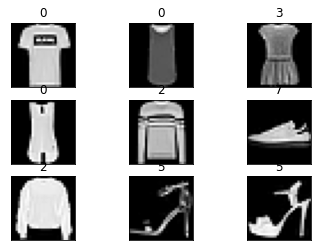

In [5]:
# Dataset shape = (60_000, 28, 28).
# 60k imagenes a escala de grises con resolución de 28x28 pixeles.

(train_imgs, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# mostrar 9 imagenes aleatorias
fig = plt.figure()
for i in range(9):
    num = np.random.randint(30_000)

    plt.subplot(3, 3, i+1)
    plt.imshow(train_imgs[i+1], cmap='gray')
    plt.title(train_labels[i+1])
    plt.xticks([])
    plt.yticks([])

In [6]:
# Se añade una cuarta dimensión y se convierte a un arreglo de numpy de tipo float32
train_imgs = train_imgs.reshape(train_imgs.shape[0], 28, 28, 1).astype('float32')

# Normalizamos la entrada en el rango de [-1, 1] ya que la capa final del generador utiliza tanh.
train_imgs = (train_imgs - 127.5) / 127.5

In [11]:
# Su objetivo principale es generar imagenes que engañen al discriminador.
# Su entrada es ruido aleatorio y la salida buscará ser similar a las de entrenamiento.
# Como las imagenes de entrenamiento son de 28x28, la salida deberá ser igual.
# Queremos hacer lo sigiente:
#  - Convertir ruido aleatorio 1D a 3D con una capa reshape.
#  - Upsamplea con Keras y la capa Conv2DTranspose hasta llegar al tamaño 28x28x1

# Dimension latente para el ruido aleatorio
LATENT_DIM = 100
# Inicialización de los pesos.
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Número de canales. 1 es para escala de grises y 3 para imagenes a color.
CHANNELS = 1

def build_generator() -> model:
    # Creamos el modelo
    generator = Sequential(name='generator')

    # Creamos una capa Densa para preparar el cambio de tamaño a 3D. Definimos también el
    # tamaño de entrada en la primer capa del modelo. Se añaden las capas BatchNormalization y ReLU
    generator.add(layers.Dense(7*7*256, input_dim=LATENT_DIM))
    generator.add(layers.BatchNormalization())
    generator.add(layers.ReLU())

    # Reshapeamos la capa anterior de 1D a 3D.
    generator.add(layers.Reshape((7, 7, 256)))

    # Sobre sampleamos dos veces con Conv2DTranspose con un paso de 2 para pasar 7x7 -> 14x14 -> 28x28
    # Sobresampleamos a 14x14 aplicando la transpuesta CONV=> BN => ReLU
    generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
    generator.add(layers.BatchNormalization())
    generator.add(layers.ReLU())

    # Sobresampleo a 28x28: aplicando la transpuesta CONV => BN => ReLU
    generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
    generator.add(layers.BatchNormalization())
    generator.add(layers.ReLU())

    # Finalmente una Conv2D con activación tanh. CHANNEL se definio como 1, lo que nos dará una imagen final de
    # 28x28x1, concordando con los tamaños de la base de datos.

    generator.add(layers.Conv2D(CHANNELS, (5, 5), padding='same', activation='tanh'))

    # Observamos el modelo de la red con summary()
    generator.summary()

    return generator

generator = build_generator()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_11 (Batc (None, 12544)             50176     
_________________________________________________________________
re_lu_10 (ReLU)              (None, 12544)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_12 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu_11 (ReLU)              (None, 14, 14, 128)       0 

In [17]:
# Se añade el modelo del discriminador.
# El discriminador es un clasificador binario que indica si una imagen es real o no. Su objetivo es
# clasificar las imagenes de manera correcta, descubriendo si son o no falsas. Aun así, hay diferencias:
# - Usamos LeakyReLU como función de activación.
# - El discriminador tiene dos grupos de imagenes de entrada, el set de entrenamiento o imagenes reales (1) y
#   las imagenes falsas creadas por el generador (0)
# Nota: El discriminante suele ser mas pequeño o simple que el generador, pues este realiza un trabajo mas sencillo
# que el Generador. Si el Discriminador es muy grande, el Generador no podrá mejorar.

def build_discriminator(width=28, height=28, depth=1, alpha=0.2):
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # Creamos una capa de entrada
    model.add(layers.InputLayer(input_shape))
    # Usamos Conv2D, BatchNormalization y LeakyReLU para downsamplear.
    model.add(layers.Conv2D(64, (14, 14), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Conv2D segunda parte
    model.add(layers.Conv2D(128, (7, 7), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Finalmente una capa de aplanado y dropout.
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # La ultima capa contiene una sigmoidal para tener una salida binaria
    model.add(layers.Dense(1, activation='sigmoid'))

    # Resumen del modelo
    model.summary()

    return model

discriminator = build_discriminator()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 14, 14, 64)        12608     
_________________________________________________________________
batch_normalization_21 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 128)         401536    
_________________________________________________________________
batch_normalization_22 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)            

## Función de pérdida
La función de pérdida es el corazón del entrenamiento de las GAN. En este caso utilizaremos la pérdida
del minimax modificado _modified minimax loss_, la cual utiliza la función de perdida de Binary Cross-entropy.

En el caso de las GAN hay 2 funciones de pérdida a calcular: la del discriminante y el del generador.

### Pérdida del discriminante

Cómo hay dos grupos de imagenes a la entrada del discriminador (reales [1] y falsas [2]), debemos calcular
la pérdida en cada uno y combinarlas para la pérdida del discriminador.

$ Total D Loss = lossRealImages + lossFakeImages $

### Pérdida del generador
En lugar de entrenar G para minimizar $ log(1 - D(G(z))) $ la probabilidad de que el D clasifique una imagen
falsa como falsa, entrenamos a G para maximizar $ log D(G(z))$ es decir, la probabilidad de que D clasifique
de manera incorrecta la imagen falsa como una real.


In [ ]:
# Creamos una subclase keras.Model para DCGAN
# Sobrecargamos el método train_step
class DCGAN(keras.Model):
    def train_step(self):
        # calculo
        with tf.GradientTape() as tape:
            # Calculamos la perdida del discriminador en imagenes reales+
            pred_real = self.disriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Calculamos la perdida del discriminador en imagenes falsas
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # perdida total del discriminador
            d_loss = (d_loss_real + d_loss_fake) / 2
        # Calcula los gradientes del discriminante
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Actualiza los pesos del discriminador
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Generador quiere que Discriminante piense que lo falso es real
        misleading_labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)

            # Calcula los gradientes del generador
            grads = tape.gradient(g_loss, self.generator.trainable_variables)
            # Se actualizan los pesos del grnerador
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

            self.d_loss_metric.update_state(d_loss)
            self.g_loss_metric.update_state(g_loss)


## Monitoreo y visualizacion
Se sobrecargara Callback() para observar:

    - Pérdida del discriminador
    - Pérdida del generador
    - Imagenes que se generen durante el entrenamiento.


Para evaluar una GAN es importante inspeccionar visualmente las imagenes generadas durante
el entrenamiento.

In [ ]:
# Ponemos todo junto
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

# Como suguiere el paper, utilizaremos Adam con un Learning Rate de 0.0002 para G y D. La función de pérdida será
# Binary cross entropy.
LR = 0.0002

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# Estamos listos para entrenar la red DCGAN con model.fit
# Definimos y entrenamos
NUM_EPOCHS = 50
dcgan.fit(train_images, epochs=NUM_EPOCHS,
          callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])


